<a href="https://colab.research.google.com/github/Ness731/AI-Lab_DeepLearning_lecture/blob/main/homework_2_1_CNN(%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망 깊게 쌓아 컬러 데이터셋에 적용하기
Convolutional Neural Network (CNN) 을 쌓아올려 딥한 러닝을 해봅시다.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
DEVICE
#CUDA 설정 방법
# 상단 런타임 --> 런타임 유형 변경 --> 하드웨어 가속기 --> GPU 설정 --> 저장 !

device(type='cuda')

## 하이퍼파라미터 

In [ ]:
# Epochs과 batch size는 변경 X 
EPOCHS     = 100
BATCH_SIZE = 32

## 데이터셋 불러오기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


torch.Size([32, 3, 32, 32])
torch.Size([32])


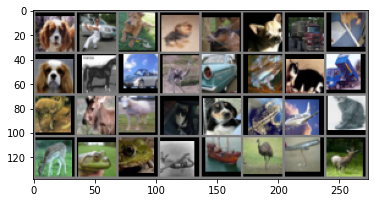

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

CIFAR10 데이터 1개는 __32x32__ 크기의 컬러 이미지(__3차원__)임을 확인하였다. 이미지의 총 개수는 32개이다.

# 모델 초기화
각 모델에 맞게 초기화를 수행하는 함수. resnet의 경우 [resnet]-[FC]-[Linear] 순으로 데이터가 흐른다.



In [ ]:
# 수정 X
def initialize_model(model_name, num_classes, use_pretrained=True):
    model_ft = None

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        # 제일 마지막 FC layer를 Cifar 클래스에 맞도록 Output 크기 교체 == 즉, resnet.fc를 새로운 nn.Linear를 정의하여 할당.
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name =='resnet101':
        model_ft = models.resnet101(use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'resnet152':
        model_ft = models.resnet152(use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        # 제일 마지막 FC layer를 Cifar 클래스에 맞도록 Output 크기 교체 == 즉, resnet.fc를 새로운 nn.Linear를 정의하여 할당.
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "base":
      model_ft = BaseModel(num_classes)
      
    return model_ft

# 과제 1번
### 나만의 CNN 모델을 만들어 CIFAR10 이미지 분류 성능 측정
#### 제공된 코드에서 BaseModel (CNN모델) 정확도 성능 올리기


(1) nn.Conv2d 함수 중 Filter의 개수, 사이즈를 조절하는 값을 찾아 변동 시킨 경우

(2) nn.Conv2d 네트워크를 추가 적용해보는 경우

(3) 기타 등등.. 다양한 방법 시도

 * BaseModel class 속 코드 변경 후 아래의 "코드 돌려보기" 부분 실행 *

-----
__나의 CNN 모델__
- CNN의 성능을 향상시키기 위해 신경망의 레이어 깊이와 각 레이어에 있는 유닛의 수를 늘려보았다.
- [conv2D - ReLu – dropout - pooling] 구조를 세 번 반복한 후 Linear 레이어를 통과한다.
- conv2D의 출력 채널 수는 두 배씩 증가한다.
- Conv2d 함수의 필터 크기를 기존의 5x5에서 3x3으로 변경하였다.
- 이미지의 가장자리 특징도 잘 반영하기 위해 Padding을 사용한다.
- 입력층에 가까울 수록 낮은 드롭아웃(dropout) 확률값을 사용하였다.

In [ ]:
class BaseModel(nn.Module):
  def __init__(self, num_classes):
    super(BaseModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    self.conv3 = nn.Conv2d(64, 128, 5, padding=2)
    self.conv4 = nn.Conv2d(128, 256, 5, padding=2)
    self.conv5 = nn.Conv2d(256, 512, 5, padding=2)
    self.conv6 = nn.Conv2d(512, 1024, 5, padding=2)

    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(1024 * 2 * 2, 128)
    self.fc2 = nn.Linear(128, num_classes)

    self.dropout_p = 0.5

  def forward(self, x):
    x = F.relu(self.conv1(x)) # Conv -> ReLU
    x = F.relu(self.conv2(x)) # Conv -> ReLU
    x = self.pool(x) # Pooling
    # feature map 크기 = 16

    x = F.relu(self.conv3(x)) # Conv -> ReLU
    x = F.relu(self.conv4(x)) # Conv -> ReLU
    x = self.pool(x) # Pooling
    # feature map 크기 = 8

    x = F.relu(self.conv5(x)) # Conv -> ReLU
    x = self.pool(x) # Pooling
    # feature map 크기 = 4

    x = F.relu(self.conv6(x)) # Conv -> ReLU
    x = self.pool(x) # Pooling
    # feature map 크기 = 2

    x = x.view(-1, 1024 * 2 * 2) # feature map을 일렬로 만든다.
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training, p = self.dropout_p) # Dropout
    x = self.fc2(x)
    return x

In [ ]:
# 아래 코드 작성하세요
num_classes = 10   # FC layer Output --> Cifar Dataset 클래스에 맞도록 변경하세요

# 과제2. ResNet_18 vs VGG_11 
### 1. ImageNet 데이터셋으로 선행 학습된 Resnet or Vgg 모델을 Cifar-10 데이터셋에 대한 전이학습을 진행해주세요

- 주의
 - resnet101, 152은 layer 깊이가 깊음 --> 학습 시간이 오래 걸림
 - 적절한 하이퍼파라미터 설정 후 실행

## 준비

In [ ]:
#아래 4가지 모델 중 하나만 주석 해제 후 사용
# Resnet-18  Load
# model = initialize_model('resnet18',num_classes, True)
# Resnet-101  Load
# model = initialize_model('resnet101',num_classes, True)
# Resnet-152  Load
# model = initialize_model('resnet152',num_classes, True)
# VGG-11 Load
# model = initialize_model('vgg',num_classes, True)

# 과제1 BaseModel Load
model = initialize_model('base', num_classes, True)
print(model)
#Learning rate 변경시 아래 lr 의 값 변경
# optimizer 함수 변경은 자유!!
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# 학습 시간이 오래 걸릴 경우에는 step_size = 5 로 변경


BaseModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(512, 1024, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 학습하기

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    model = model.to(DEVICE)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 테스트하기

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 코드 돌려보기

자, 이제 모든 준비가 끝났습니다. 코드를 돌려서 실제로 훈련이 되는지 확인해봅시다!

In [ ]:
model = model.to(DEVICE)
for epoch in range(1, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1] Test Loss: 1.7880, Accuracy: 31.59%
[2] Test Loss: 1.4212, Accuracy: 48.17%


# 과제 3. 사전 학습이 완료된 ResNet-18 모델의 Conv Layer 시각화

### Conv Layer 깊이에 따른 특징 맵을 분석해주세요!
  -> ex ) Conv 0 Layer에서는 이미지의 윤곽선에 대한 특징을 추출했다면, Conv 4 Layer에서는 이미지의 색에 대한 특징을 추출하였습니다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1 , 2 , 0) # transposing the image matrix
    image = image * np.array((0.5 , 0.5 , 0.5)) + np.array((0.5 , 0.5 , 0.5)) # applying transform to the trnsor
    image = image.clip(0,1)
    return image

class Conv_layervis(nn.Module):
    def __init__(self,layer,img,layer_num):
        super(Conv_layervis , self).__init__()
         
        self.layer = layer
        self.img = img
        self.weights = self.layer.weight.data # Load the weights
        self.layer_num = layer_num
        self.w = self.weights.cpu().numpy()
        
        self.fig = plt.figure(figsize = (30 , 10))

        self.columns = 5*2
        self.rows = 2

        for i in range(self.columns * self.rows):
            self.fig.add_subplot(self.rows , self.columns , i+1)
            if(i%2 == 0):
                plt.title('Conv {} Filter'.format(self.layer_num))
                plt.imshow(self.w[int(i/2)][0] , cmap = 'gray')
            else:
                self.c = cv2.filter2D(self.img , -1 , self.w[int((i-1)/2)][0])
                plt.title('Conv {} Image'.format(self.layer_num))
                plt.imshow(self.c , cmap = 'gray')


 

In [ ]:
# ResNet 모델 Conv Filter 시각화

images , labels = next(iter(test_loader))

model = initialize_model("resnet18",num_classes,True)

model_conv_layer = {'resnet' :[model.conv1,model.layer1[0].conv1,model.layer2[0].conv1,model.layer3[0].conv1,model.layer4[0].conv1]}
model_name = 'resnet'

for layer_num,conv_layer in enumerate(model_conv_layer[model_name]):
  Conv_layervis(conv_layer , im_convert(images[0]),layer_num)